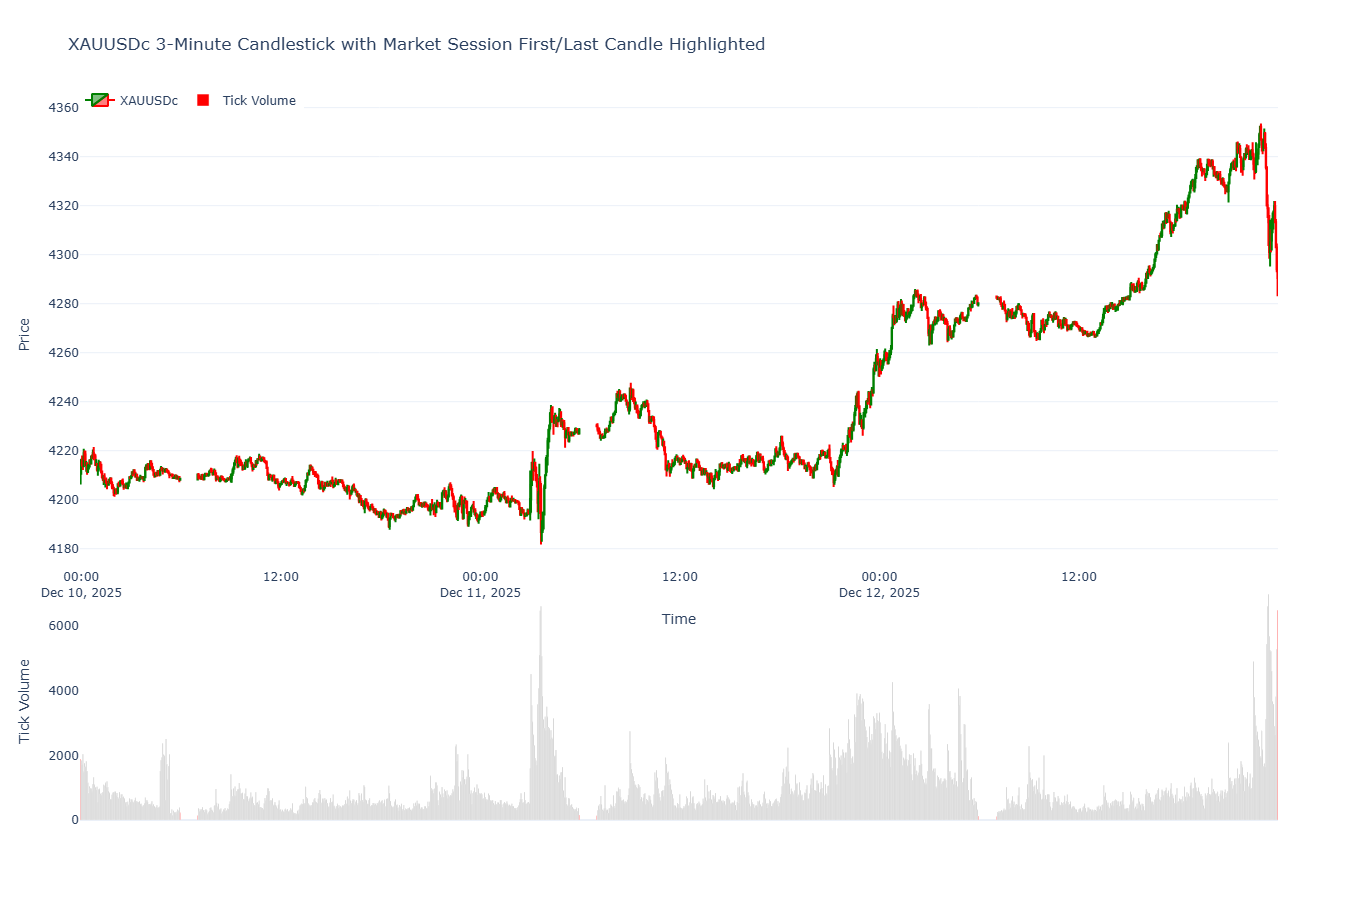

In [2]:
import MetaTrader5 as mt5
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta, time
import pytz

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 1500
utc_from = datetime.now() - timedelta(days=1)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Manila')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove weekends
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Assign session key based on market open (06:00) to market close (next day 05:00)
# -------------------------
market_open = time(6, 0)
market_close = time(5, 0)

def get_session(dt):
    if dt.time() >= market_open:
        return dt.date()
    else:
        # belongs to previous day's session
        return (dt - pd.Timedelta(days=1)).date()

df['session'] = df.index.map(get_session)

# -------------------------
# 6. Identify first and last candle of each session
# -------------------------
first_candle_idx = df.groupby('session').head(1).index
last_candle_idx = df.groupby('session').tail(1).index

# -------------------------
# 7. Plot 2-Pane Chart
# -------------------------
fig = go.Figure()

# Candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick Volume with highlighted first/last bars
colors = ['red' if idx in first_candle_idx or idx in last_candle_idx else 'gray' for idx in df.index]
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color=colors,
    yaxis='y2'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick with Market Session First/Last Candle Highlighted',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.0, 0.33], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


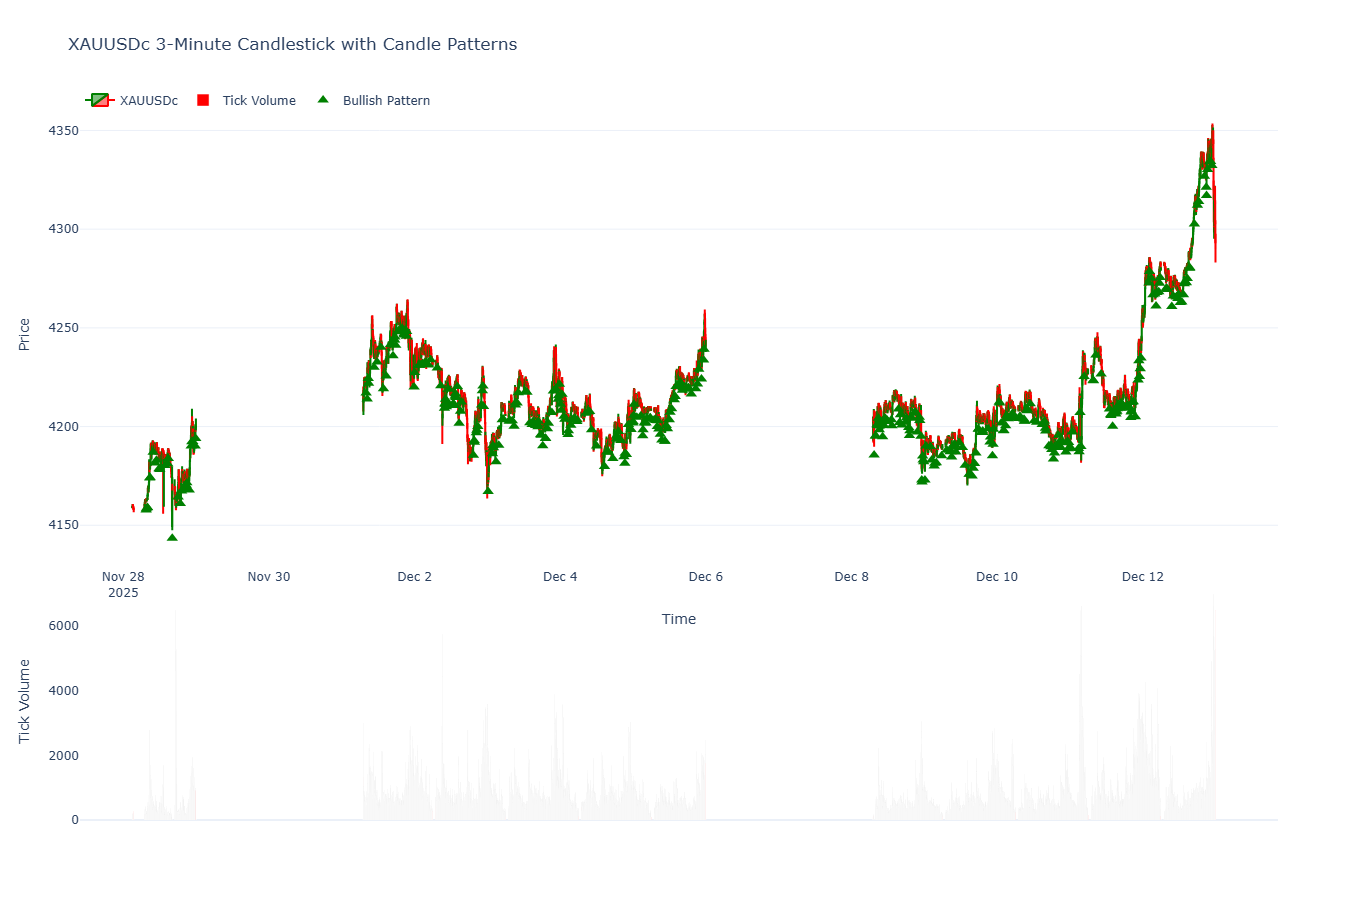

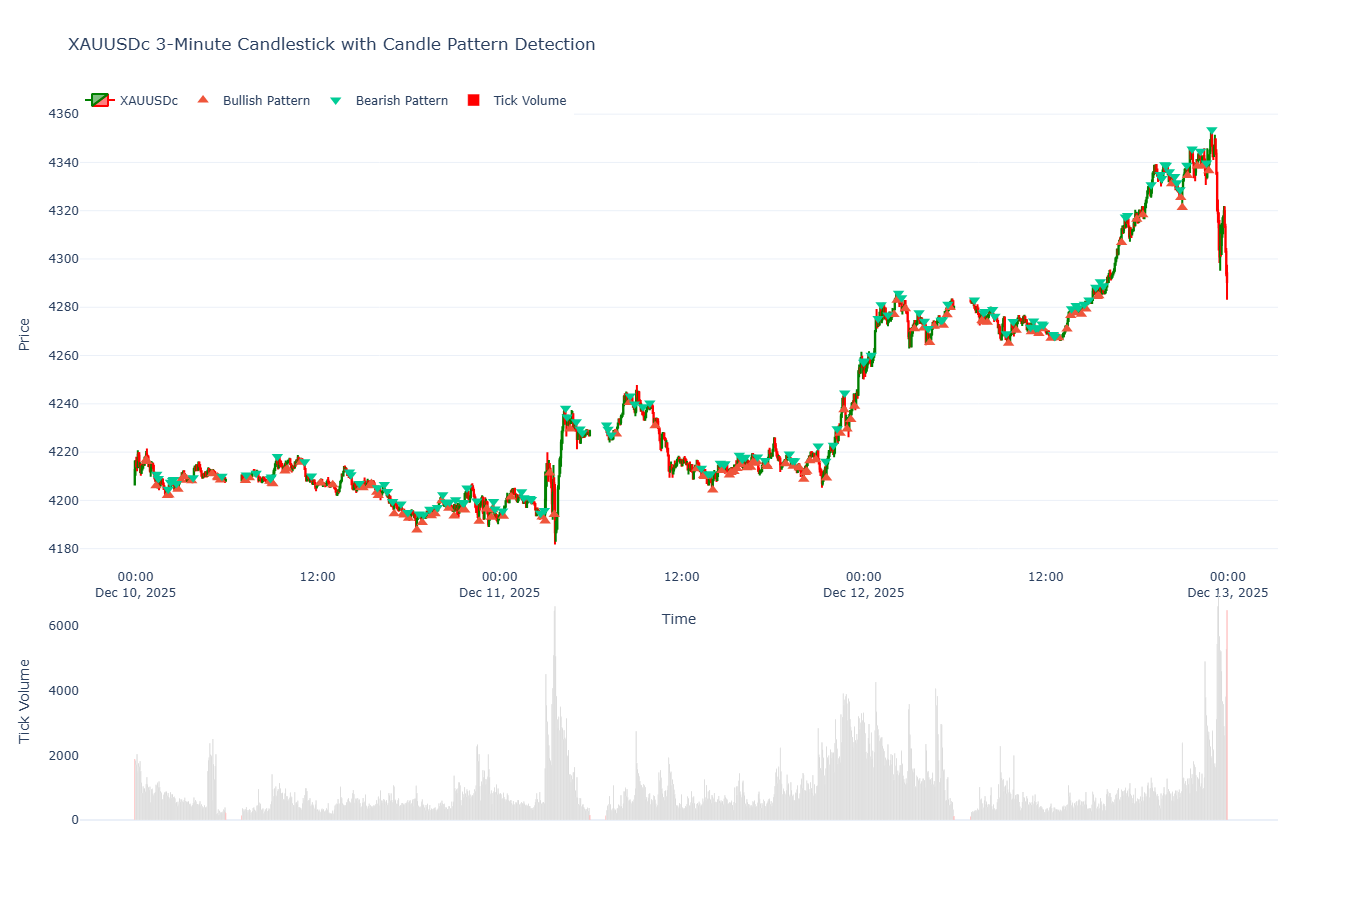

In [5]:
import MetaTrader5 as mt5
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta, time
import pytz

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 1500
utc_from = datetime.now() - timedelta(days=1)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Manila')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove weekends
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Assign session key
# -------------------------
market_open = time(6, 0)
market_close = time(5, 0)

def get_session(dt):
    if dt.time() >= market_open:
        return dt.date()
    else:
        return (dt - pd.Timedelta(days=1)).date()

df['session'] = df.index.map(get_session)

# -------------------------
# 6. Identify first and last candle of each session
# -------------------------
first_candle_idx = df.groupby('session').head(1).index
last_candle_idx = df.groupby('session').tail(1).index

# -------------------------
# 7. Candle Pattern Logic
# -------------------------
df['bullish_pattern'] = (
    (df['low'] < df['low'].shift(1)) &
    (df['close'] > df['open'].shift(1))
)

df['bearish_pattern'] = (
    (df['high'] > df['high'].shift(1)) &
    (df['close'] < df['open'].shift(1))
)

# -------------------------
# 8. Plot 2-Pane Chart
# -------------------------
fig = go.Figure()

fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Bullish markers
fig.add_trace(go.Scatter(
    x=df.index[df['bullish_pattern']],
    y=df['low'][df['bullish_pattern']],
    mode='markers',
    name='Bullish Pattern',
    marker=dict(symbol='triangle-up', size=10),
))

# Bearish markers
fig.add_trace(go.Scatter(
    x=df.index[df['bearish_pattern']],
    y=df['high'][df['bearish_pattern']],
    mode='markers',
    name='Bearish Pattern',
    marker=dict(symbol='triangle-down', size=10),
))

# Tick Volume
colors = ['red' if idx in first_candle_idx or idx in last_candle_idx else 'gray' for idx in df.index]
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color=colors,
    yaxis='y2'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick with Candle Pattern Detection',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.0, 0.33], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


In [ ]:
How the black candle coloring works

Plotly does not support per-bar coloring inside a single Candlestick trace, so the correct and clean approach is:

Split candles into two traces:

Normal candles

Black candles (market open & market close only)

This is the only reliable way to achieve true candle coloring without hacks.

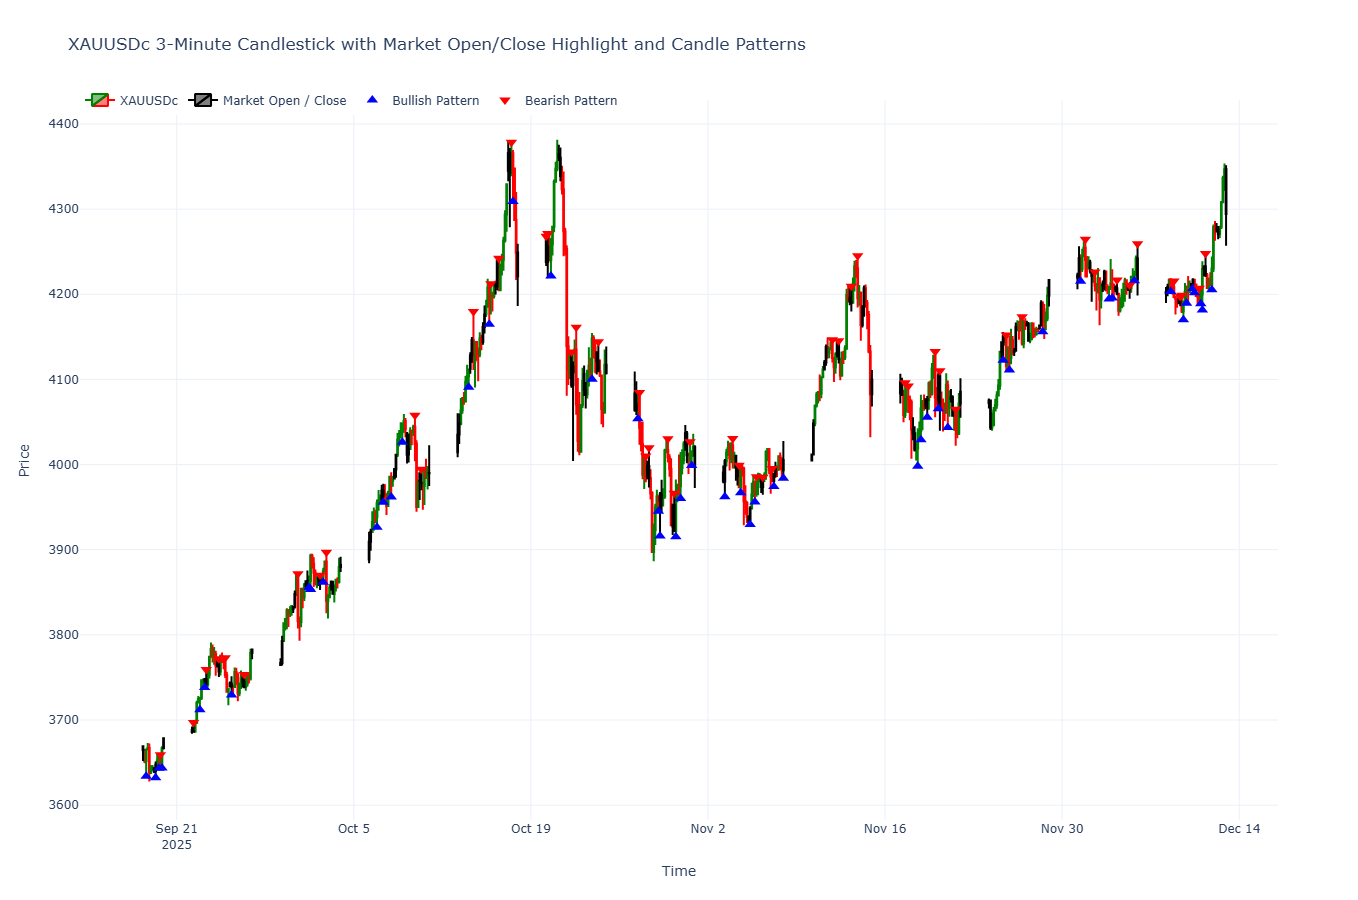

In [12]:
import MetaTrader5 as mt5
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta, time

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_H3
n_bars = 500
utc_from = datetime.now() - timedelta(days=1)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Manila')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove weekends
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Assign session key (06:00 → 05:00)
# -------------------------
market_open = time(6, 0)
market_close = time(5, 0)

def get_session(dt):
    if dt.time() >= market_open:
        return dt.date()
    else:
        return (dt - pd.Timedelta(days=1)).date()

df['session'] = df.index.map(get_session)

# -------------------------
# 6. Identify market open and close candles
# -------------------------
open_idx = df.groupby('session').head(1).index
close_idx = df.groupby('session').tail(1).index
black_idx = open_idx.union(close_idx)

# -------------------------
# 7. Candle Pattern Logic
# -------------------------
df['bullish_pattern'] = (
    (df['low'] < df['low'].shift(1)) &
    (df['close'] > df['open'].shift(1))
)

df['bearish_pattern'] = (
    (df['high'] > df['high'].shift(1)) &
    (df['close'] < df['open'].shift(1))
)

# -------------------------
# 8. Plot Candles
# -------------------------
fig = go.Figure()

# Normal candles
normal_df = df[~df.index.isin(black_idx)]

fig.add_trace(go.Candlestick(
    x=normal_df.index,
    open=normal_df['open'],
    high=normal_df['high'],
    low=normal_df['low'],
    close=normal_df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Market open / close candles (black)
black_df = df[df.index.isin(black_idx)]

fig.add_trace(go.Candlestick(
    x=black_df.index,
    open=black_df['open'],
    high=black_df['high'],
    low=black_df['low'],
    close=black_df['close'],
    name='Market Open / Close',
    increasing_line_color='black',
    decreasing_line_color='black'
))

# Bullish pattern markers (BLUE)
fig.add_trace(go.Scatter(
    x=df.index[df['bullish_pattern']],
    y=df['low'][df['bullish_pattern']],
    mode='markers',
    name='Bullish Pattern',
    marker=dict(
        symbol='triangle-up',
        size=10,
        color='blue'
    )
))

# Bearish pattern markers (RED)
fig.add_trace(go.Scatter(
    x=df.index[df['bearish_pattern']],
    y=df['high'][df['bearish_pattern']],
    mode='markers',
    name='Bearish Pattern',
    marker=dict(
        symbol='triangle-down',
        size=10,
        color='red'
    )
))

# -------------------------
# 9. Layout
# -------------------------
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick with Market Open/Close Highlight and Candle Patterns',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


In [ ]:
Mark the 8am candle at H3 timeframe, box it red if its bearish (from high to close) and blue if bullish (from low to close), use 2 bars wide for the box

What is added and how it works:

Timeframe is H3, already correct

Only candles with local time = 08:00 (Asia/Manila) are processed

Each 08:00 candle is boxed using a Plotly rectangle shape

Box width = 2 bars → 6 hours (H3 × 2)

Bullish candle

close > open

Box from low → close

Box color blue

Bearish candle

close < open

Box from high → close

Box color red

Boxes are drawn on top of the price chart, not as traces

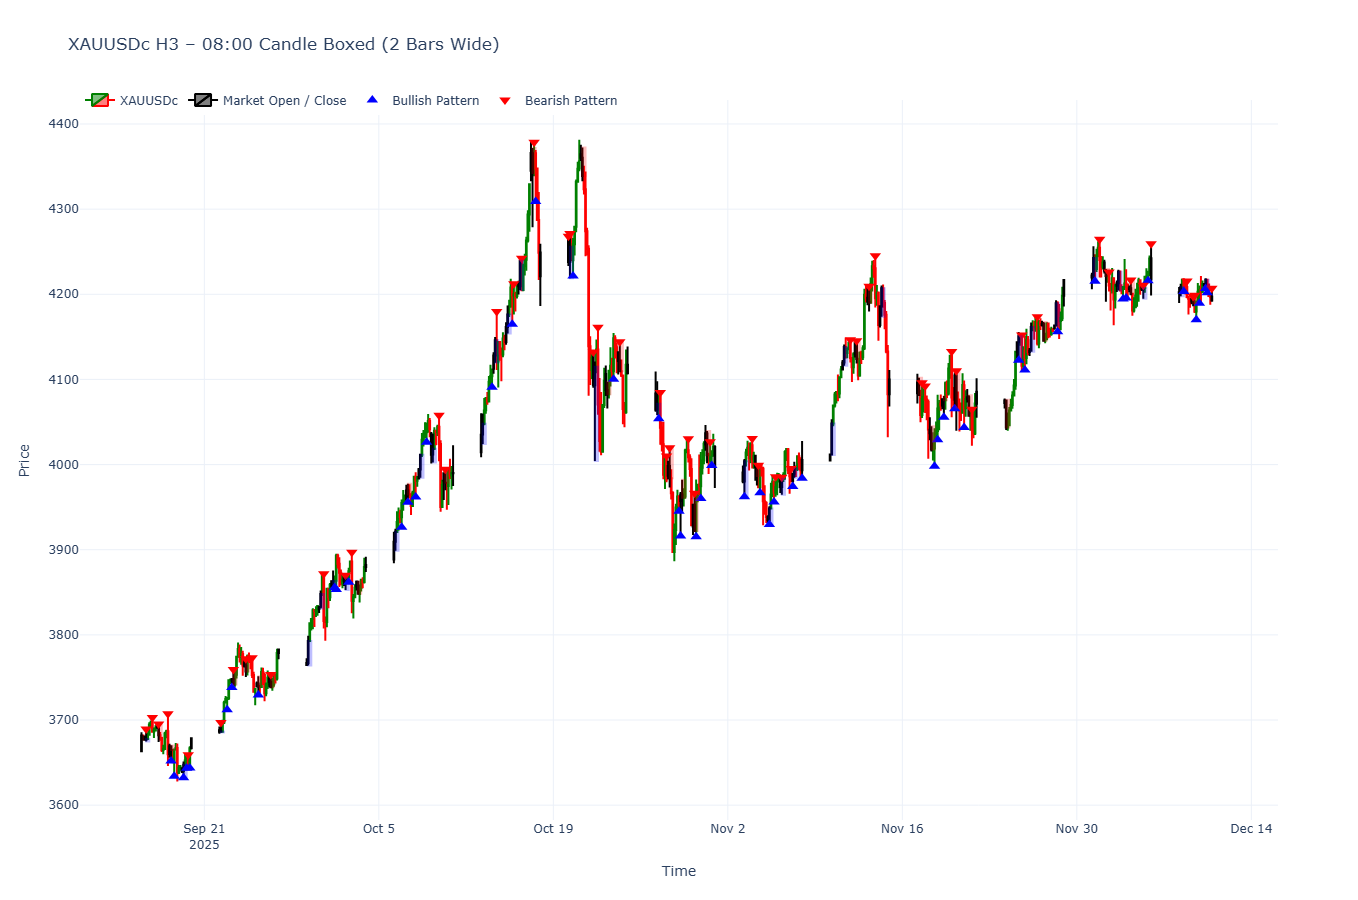

In [13]:
import MetaTrader5 as mt5
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta, time

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch H3 data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_H3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Manila')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove weekends
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Assign session key (06:00 → 05:00)
# -------------------------
market_open = time(6, 0)

def get_session(dt):
    if dt.time() >= market_open:
        return dt.date()
    else:
        return (dt - pd.Timedelta(days=1)).date()

df['session'] = df.index.map(get_session)

# -------------------------
# 6. Identify market open and close candles
# -------------------------
open_idx = df.groupby('session').head(1).index
close_idx = df.groupby('session').tail(1).index
black_idx = open_idx.union(close_idx)

# -------------------------
# 7. Candle Pattern Logic
# -------------------------
df['bullish_pattern'] = (
    (df['low'] < df['low'].shift(1)) &
    (df['close'] > df['open'].shift(1))
)

df['bearish_pattern'] = (
    (df['high'] > df['high'].shift(1)) &
    (df['close'] < df['open'].shift(1))
)

# -------------------------
# 8. Plot Candles
# -------------------------
fig = go.Figure()

# Normal candles
normal_df = df[~df.index.isin(black_idx)]

fig.add_trace(go.Candlestick(
    x=normal_df.index,
    open=normal_df['open'],
    high=normal_df['high'],
    low=normal_df['low'],
    close=normal_df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Market open / close candles (black)
black_df = df[df.index.isin(black_idx)]

fig.add_trace(go.Candlestick(
    x=black_df.index,
    open=black_df['open'],
    high=black_df['high'],
    low=black_df['low'],
    close=black_df['close'],
    name='Market Open / Close',
    increasing_line_color='black',
    decreasing_line_color='black'
))

# -------------------------
# 9. Mark 08:00 H3 Candle with Boxes
# -------------------------
bar_width = timedelta(hours=6)  # 2 H3 bars

for ts, row in df.iterrows():
    if ts.time() == time(8, 0):

        x0 = ts
        x1 = ts + bar_width

        if row['close'] > row['open']:
            y0 = row['low']
            y1 = row['close']
            color = 'blue'
        else:
            y0 = row['close']
            y1 = row['high']
            color = 'red'

        fig.add_shape(
            type='rect',
            xref='x',
            yref='y',
            x0=x0,
            x1=x1,
            y0=y0,
            y1=y1,
            line=dict(color=color, width=2),
            fillcolor=color,
            opacity=0.25
        )

# -------------------------
# 10. Pattern Markers
# -------------------------
fig.add_trace(go.Scatter(
    x=df.index[df['bullish_pattern']],
    y=df['low'][df['bullish_pattern']],
    mode='markers',
    name='Bullish Pattern',
    marker=dict(symbol='triangle-up', size=10, color='blue')
))

fig.add_trace(go.Scatter(
    x=df.index[df['bearish_pattern']],
    y=df['high'][df['bearish_pattern']],
    mode='markers',
    name='Bearish Pattern',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

# -------------------------
# 11. Layout
# -------------------------
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc H3 – 08:00 Candle Boxed (2 Bars Wide)',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


Do not delete anything from the code, just add a logic where {Conduct a backtest (use realistic trade executions similar in live environment): If the pattern is bullish, then buy at the close,e and the stoploss is at the low of the corresponding candle. If the pattern is bearish, then sell at the close, and the stoploss is at the high of the corresponding candle. The take-profit distance varies depending on the trailing mechanics. If bullish entry, then only trail the stoploss if the preceding candles are bullish and place the trail at the low of the bullish candle. If bearish entry, then only trail the stoploss if the preceding candles are bearish and place the trail at the high of the bearish candle. 1% risk per trade with an initial capital of 1000. And: (Random slippage of 0-2 price units, spread of 0.60 price units (0.60 in entry, 0.60 in exit), and commission of 2% per trade. All of these apply in individual entries and exits) Print the dataframe for raw trades results, covering risked money (from percent), entry and exit time, stoploss and takeprofit distance, entry and exit prices and types, slippage, spread, commission cost, net pnl, equity, and many more. All trades are only valid within their corresponding trading day from pre-market open to overnight close. Print the data frame in a continuous column manner. Use a green breakline if entry to take profit, and a red breakline if entry to stoploss. On the chart. } Be careful and reread the task,

                   entry_time                 exit_time direction  \
0   2025-09-16 08:00:00+08:00 2025-09-16 14:00:00+08:00      sell   
1   2025-09-16 20:00:00+08:00 2025-09-17 20:00:00+08:00      sell   
2   2025-09-17 08:00:00+08:00 2025-09-17 20:00:00+08:00      sell   
3   2025-09-18 02:00:00+08:00 2025-09-18 17:00:00+08:00      sell   
4   2025-09-18 08:00:00+08:00 2025-09-18 11:00:00+08:00       buy   
..                        ...                       ...       ...   
99  2025-12-09 14:00:00+08:00 2025-12-09 20:00:00+08:00       buy   
100 2025-12-09 20:00:00+08:00 2025-12-10 11:00:00+08:00       buy   
101 2025-12-10 08:00:00+08:00 2025-12-10 11:00:00+08:00       buy   
102 2025-12-10 11:00:00+08:00 2025-12-10 14:00:00+08:00       buy   
103 2025-12-10 20:00:00+08:00 2025-12-10 20:00:00+08:00      sell   

     entry_price  exit_price  stoploss  risk_amount        pnl      equity  \
0    3677.109199    3690.080  3689.480    10.000000 -33.570801  966.429199   
1    3685.80832

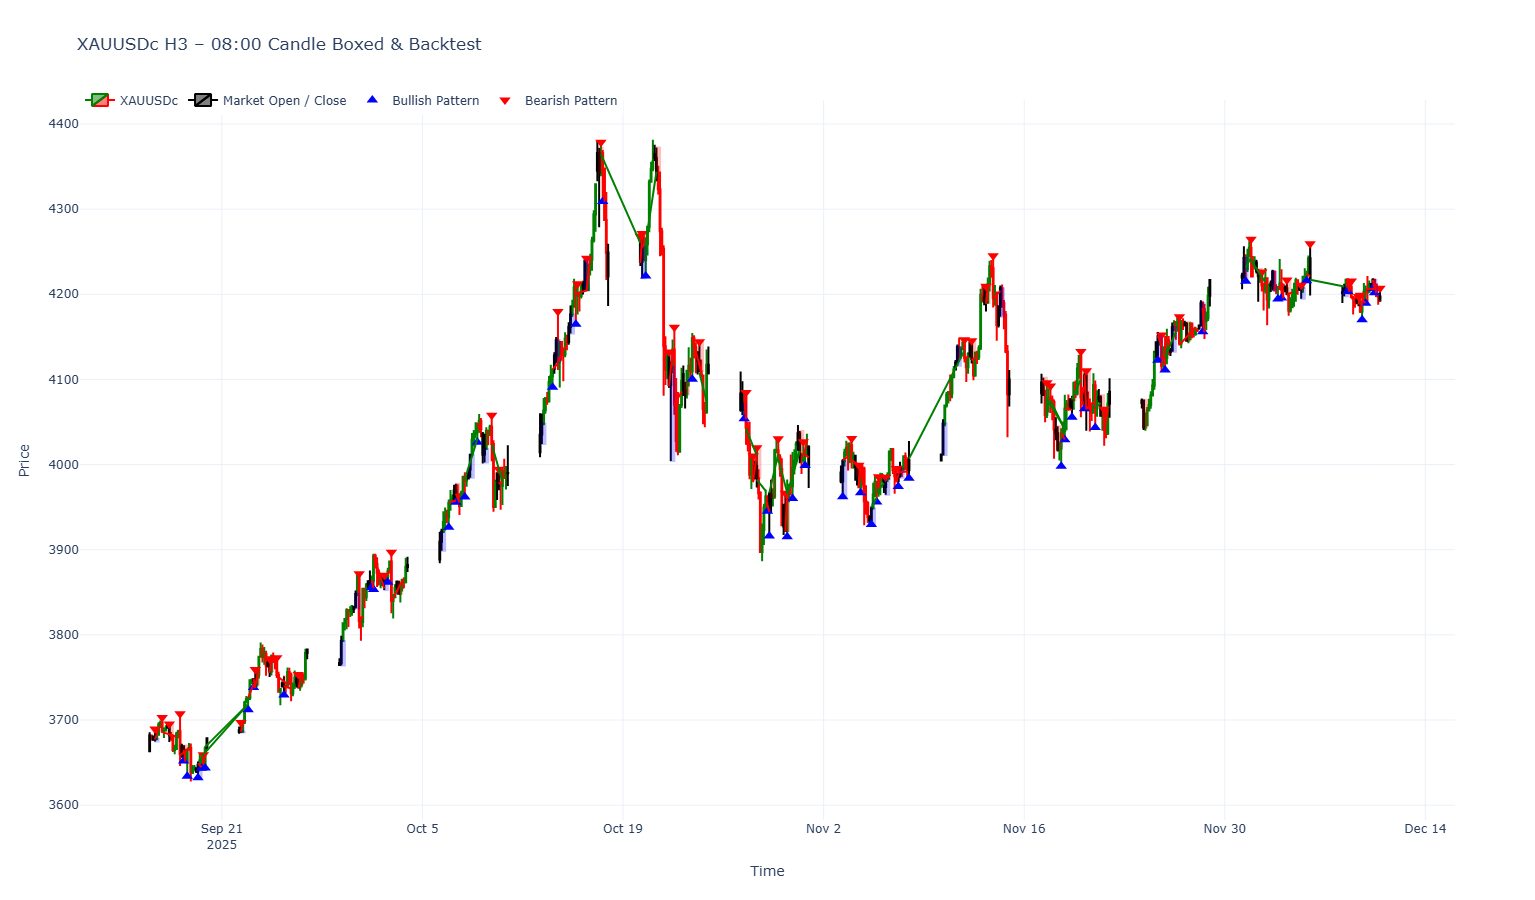

In [18]:
import MetaTrader5 as mt5
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta, time
import numpy as np
import random

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch H3 data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_H3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Manila')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove weekends
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Assign session key (06:00 → 05:00)
# -------------------------
market_open = time(6, 0)

def get_session(dt):
    if dt.time() >= market_open:
        return dt.date()
    else:
        return (dt - timedelta(days=1)).date()

df['session'] = df.index.map(get_session)

# -------------------------
# 6. Identify market open and close candles
# -------------------------
open_idx = df.groupby('session').head(1).index
close_idx = df.groupby('session').tail(1).index
black_idx = open_idx.union(close_idx)

# -------------------------
# 7. Candle Pattern Logic
# -------------------------
df['bullish_pattern'] = (df['low'] < df['low'].shift(1)) & (df['close'] > df['open'].shift(1))
df['bearish_pattern'] = (df['high'] > df['high'].shift(1)) & (df['close'] < df['open'].shift(1))

# -------------------------
# 8. Plot Candles
# -------------------------
fig = go.Figure()
normal_df = df[~df.index.isin(black_idx)]
fig.add_trace(go.Candlestick(
    x=normal_df.index,
    open=normal_df['open'],
    high=normal_df['high'],
    low=normal_df['low'],
    close=normal_df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))
black_df = df[df.index.isin(black_idx)]
fig.add_trace(go.Candlestick(
    x=black_df.index,
    open=black_df['open'],
    high=black_df['high'],
    low=black_df['low'],
    close=black_df['close'],
    name='Market Open / Close',
    increasing_line_color='black',
    decreasing_line_color='black'
))

# -------------------------
# 9. Mark 08:00 H3 Candle with Boxes
# -------------------------
bar_width = timedelta(hours=6)
for ts, row in df.iterrows():
    if ts.time() == time(8,0):
        x0 = ts
        x1 = ts + bar_width
        if row['close'] > row['open']:
            y0 = row['low']
            y1 = row['close']
            color = 'blue'
        else:
            y0 = row['close']
            y1 = row['high']
            color = 'red'
        fig.add_shape(type='rect', xref='x', yref='y', x0=x0, x1=x1, y0=y0, y1=y1,
                      line=dict(color=color, width=2), fillcolor=color, opacity=0.25)

# -------------------------
# 10. Pattern Markers
# -------------------------
fig.add_trace(go.Scatter(
    x=df.index[df['bullish_pattern']],
    y=df['low'][df['bullish_pattern']],
    mode='markers',
    name='Bullish Pattern',
    marker=dict(symbol='triangle-up', size=10, color='blue')
))
fig.add_trace(go.Scatter(
    x=df.index[df['bearish_pattern']],
    y=df['high'][df['bearish_pattern']],
    mode='markers',
    name='Bearish Pattern',
    marker=dict(symbol='triangle-down', size=10, color='red')
))

# -------------------------
# 11. Backtest Logic
# -------------------------
initial_capital = 1000
risk_per_trade = 0.01
equity = initial_capital
trades = []

for ts, row in df.iterrows():
    if not (row['bullish_pattern'] or row['bearish_pattern']):
        continue
    # Determine direction
    direction = 'buy' if row['bullish_pattern'] else 'sell'
    entry_price = row['close'] + random.uniform(0,2) if direction=='buy' else row['close'] - random.uniform(0,2)
    spread = 0.6
    commission = 0.02*equity
    risk_amount = equity * risk_per_trade
    sl = row['low'] if direction=='buy' else row['high']
    tp_price = None
    stop_hit = False
    # Scan subsequent candles for trailing stop
    for next_ts, next_row in df.loc[ts:].iterrows():
        if direction=='buy' and next_row['low'] < sl:
            exit_price = sl - spread
            stop_hit = True
            break
        elif direction=='sell' and next_row['high'] > sl:
            exit_price = sl + spread
            stop_hit = True
            break
        # Trailing logic
        if direction=='buy' and next_row['close'] > next_row['open']:
            sl = max(sl, next_row['low'])
        if direction=='sell' and next_row['close'] < next_row['open']:
            sl = min(sl, next_row['high'])
    if not stop_hit:
        exit_price = df['close'].iloc[-1]  # last candle
    pnl = (exit_price - entry_price) if direction=='buy' else (entry_price - exit_price)
    pnl -= spread + commission
    equity += pnl
    trades.append({
        'entry_time': ts,
        'exit_time': next_ts,
        'direction': direction,
        'entry_price': entry_price,
        'exit_price': exit_price,
        'stoploss': sl,
        'risk_amount': risk_amount,
        'pnl': pnl,
        'equity': equity,
        'spread': spread,
        'commission': commission
    })

# -------------------------
# 12. Print Trades DataFrame
# -------------------------
trades_df = pd.DataFrame(trades)
pd.set_option('display.max_columns', None)
print(trades_df)

# -------------------------
# 13. Add Breaklines for TP/SL
# -------------------------
for trade in trades:
    color = 'green' if trade['pnl']>0 else 'red'
    fig.add_shape(type='line', x0=trade['entry_time'], x1=trade['exit_time'],
                  y0=trade['entry_price'], y1=trade['exit_price'],
                  line=dict(color=color, width=2))

# -------------------------
# 14. Layout
# -------------------------
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc H3 – 08:00 Candle Boxed & Backtest',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()
